# Empirical mode decomposition

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np

In [2]:
import scipy.signal

dt = 0.004
f0 = 4.0
t1 = 6.0
f1 = 24.0
timebase = np.arange(0, t1, dt)
chirp = 0.9 * scipy.signal.chirp(timebase, f0, t1, f1, method='quadratic') + timebase**2 / 36

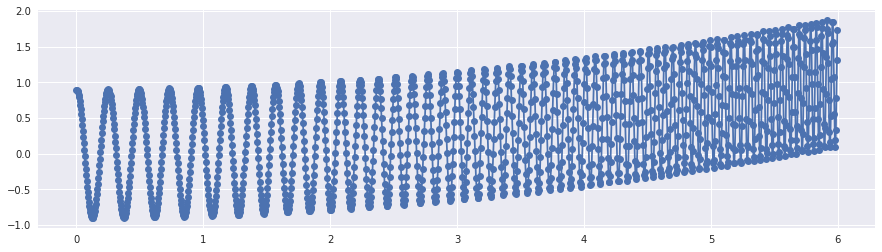

In [3]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(timebase, chirp, 'o-')
plt.show()

## More signals

In [4]:
ls benchmark_signals

bat_352800Hz.txt     irma_1Hz.txt         old/             seismic_250Hz.txt
earthquake_20Hz.txt  landslide_100Hz.txt  raw/             seismic_500Hz.txt
ecg_500Hz.txt        nuclear_20Hz.txt     seg_44100Hz.txt


In [5]:
signal = np.loadtxt('benchmark_signals/ecg_500Hz.txt')

In [6]:
fs = 500

dt = 1 / fs
n = signal.size
t = np.arange(0.0, n*dt, dt)

In [7]:
import IPython.display as ipd

ipd.Audio(signal, rate=fs)

## Naive implementation

Using the algorithm described on [this Wikipedia page](https://en.wikipedia.org/wiki/Hilbert%E2%80%93Huang_transform). 

In [8]:
from scipy.signal import argrelextrema

ma = argrelextrema(signal, np.greater)
mi = argrelextrema(signal, np.less)

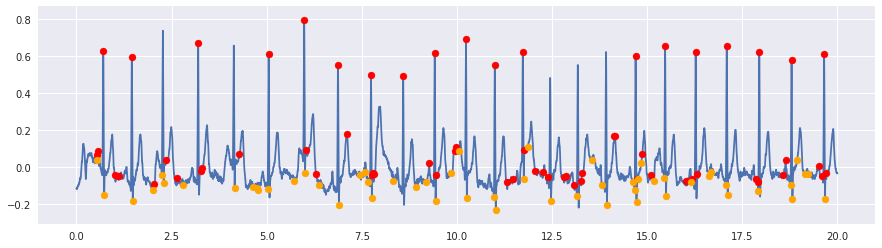

In [9]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(t, signal)
ax.scatter(t[ma], signal[ma], c='red', zorder=100)
ax.scatter(t[mi], signal[mi], c='orange', zorder=100)
plt.show()

In [10]:
from scipy.interpolate import interp1d

func = interp1d(t[ma], signal[ma], kind='cubic', bounds_error=False)
ma_env = func(t)

func = interp1d(t[mi], signal[mi], kind='cubic', bounds_error=False)
mi_env = func(t)

h1 = signal - (ma_env + mi_env) / 2

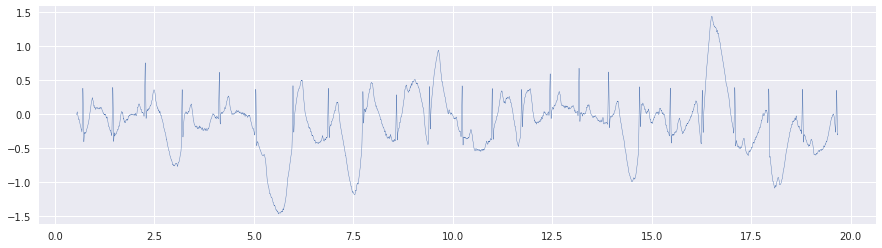

In [11]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(t, h1, lw=0.4)
plt.show()

At this point we should 'sift' h1 by repeatedly subjecting `h1` to the same process, but we'll satisfy ourselves with a single iteration and call this the first IMF, or instrinsic mode function.

Let's first turn the previous code blocks into a function:

In [12]:
def extract(t, s):
    ma = argrelextrema(s, np.greater)
    try:
        func = interp1d(t[ma], s[ma], kind='cubic', bounds_error=False)
    except:
        return s
    ma_env = func(t)

    mi = argrelextrema(s, np.less)
    try:
        func = interp1d(t[mi], s[mi], kind='cubic', bounds_error=False)
    except:
        return s
    mi_env = func(t)

    return s - (ma_env + mi_env) / 2

Now we can remove this component from the data, and repeat the process on the residual.

In [13]:
r1 = signal - h1

/home/matt/anaconda3/envs/geocomp/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/home/matt/anaconda3/envs/geocomp/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)
/home/matt/anaconda3/envs/geocomp/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
/home/matt/anaconda3/envs/geocomp/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)


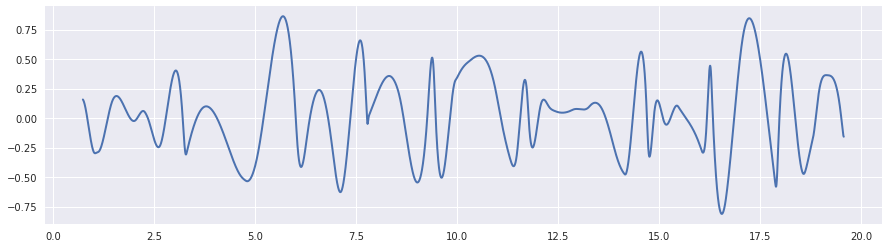

In [14]:
h2 = extract(t, r1)

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(t, h2, lw=2)
plt.show()

We have reached an essentially monotonic signal, so there are no local minima or maxima, and this is the end of the process. The new residual has zero amplitude:

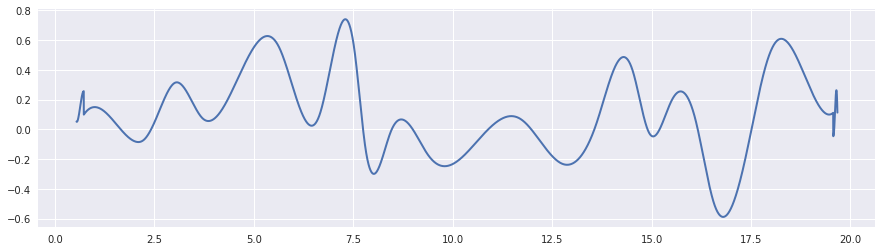

In [15]:
r2 = r1 - np.nan_to_num(h2, 0)

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(t, r2, lw=2)
plt.show()

## PyEMD by David Laszuk

It turns out we don't need to 

[PyEMD](https://github.com/laszukdawid/PyEMD) is a small Python library by [David Laszuk](https://laszukdawid.com/about/).

In [16]:
from PyEMD import EMD

_ = np.random.random(100)
emd = EMD()

In [17]:
IMFs = emd(signal)

INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.


In [18]:
IMFs

array([[ 1.46731378e-03,  1.46535886e-03, -1.45570158e-03, ...,
         5.42341374e-04,  1.18940474e-03,  1.72567692e-03],
       [ 1.52941175e-03,  1.52933404e-03,  6.00872497e-05, ...,
        -2.93337282e-03, -1.93684503e-03, -4.00251829e-04],
       [ 3.33478512e-04,  3.33560762e-04,  1.04935454e-04, ...,
         1.31711530e-03,  7.83934838e-05, -1.67964376e-03],
       ...,
       [ 3.98727907e-03,  3.99975597e-03,  4.01220685e-03, ...,
         7.29460373e-03,  7.29404546e-03,  7.29348425e-03],
       [-8.08882336e-04, -8.09127421e-04, -8.09377935e-04, ...,
        -6.50586657e-03, -6.50508979e-03, -6.50431267e-03],
       [ 4.88993227e-04,  4.89602233e-04,  4.90211383e-04, ...,
         2.21776630e-03,  2.21730300e-03,  2.21683973e-03]])

In [19]:
IMFs.shape

(17, 10000)

In [20]:
def plots(imfs):
    nrows = imfs.shape[0]
    fig, axs = plt.subplots(figsize=(15, 2*nrows), nrows=nrows)
    
    for ax, imf in zip(axs, imfs):
        ax.plot(imf)
        fig.canvas.draw()  # To make the ticks available
        labels = [l.get_text() for l in ax.get_xticklabels()]
        ax.set_xticklabels([])
    ax.set_xticklabels(labels)
    
    plt.show()
    
    return

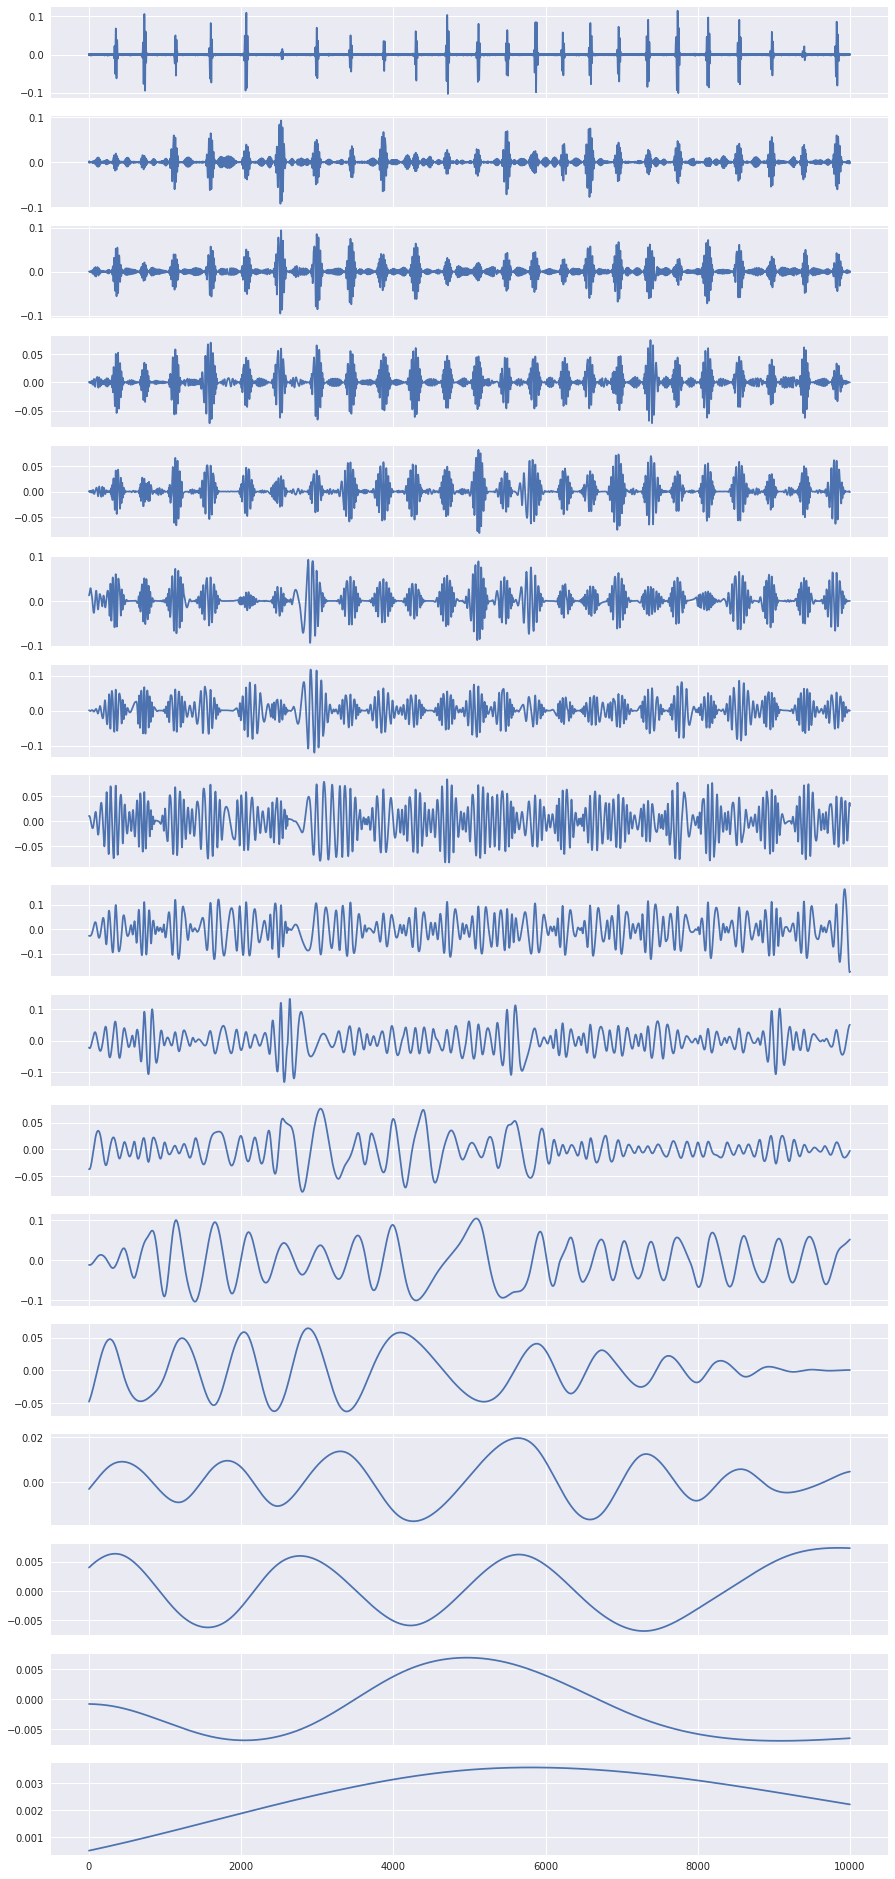

In [21]:
plots(imfs=IMFs)

In [22]:
from PyEMD import EEMD

_ = np.random.random(100)
eemd = EEMD()
eIMFs = eemd(signal)

In [23]:
eIMFs.shape

(16, 10000)

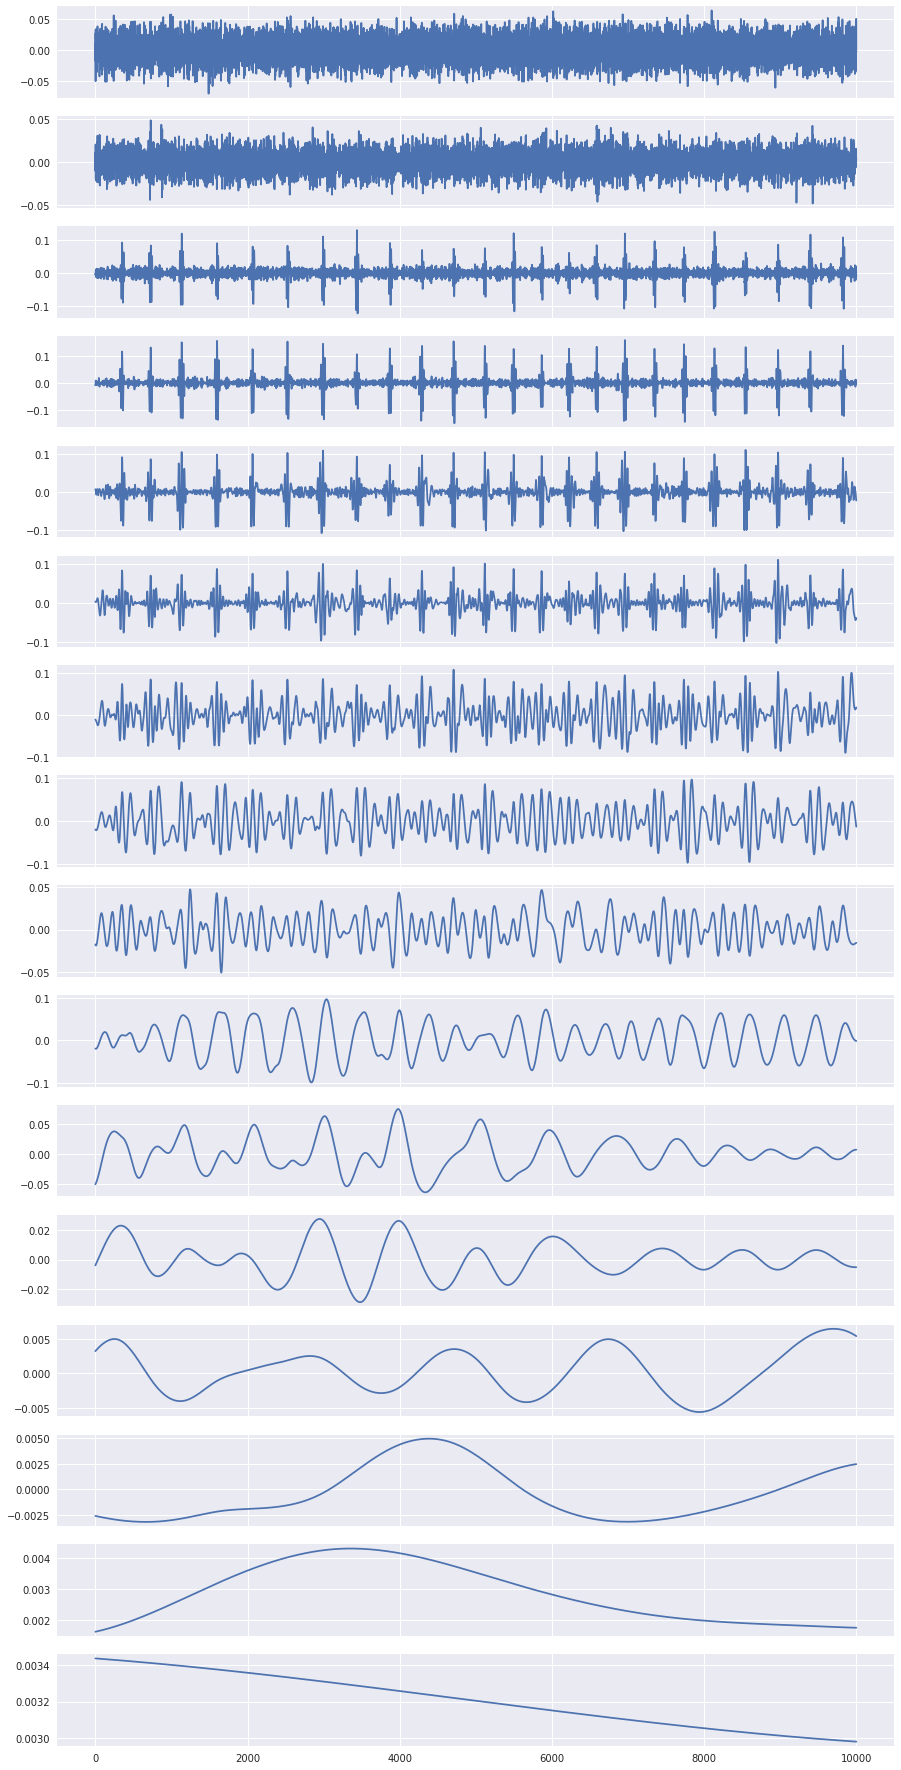

In [24]:
plots(eIMFs)

In [25]:
from PyEMD import CEEMDAN

_ = np.random.random(100)
ceemd = CEEMDAN()
ceIMFs = ceemd(signal)

INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.

INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.

INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.

INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.

INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.

INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.

INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.

In [26]:
ceIMFs.shape

(19, 10000)

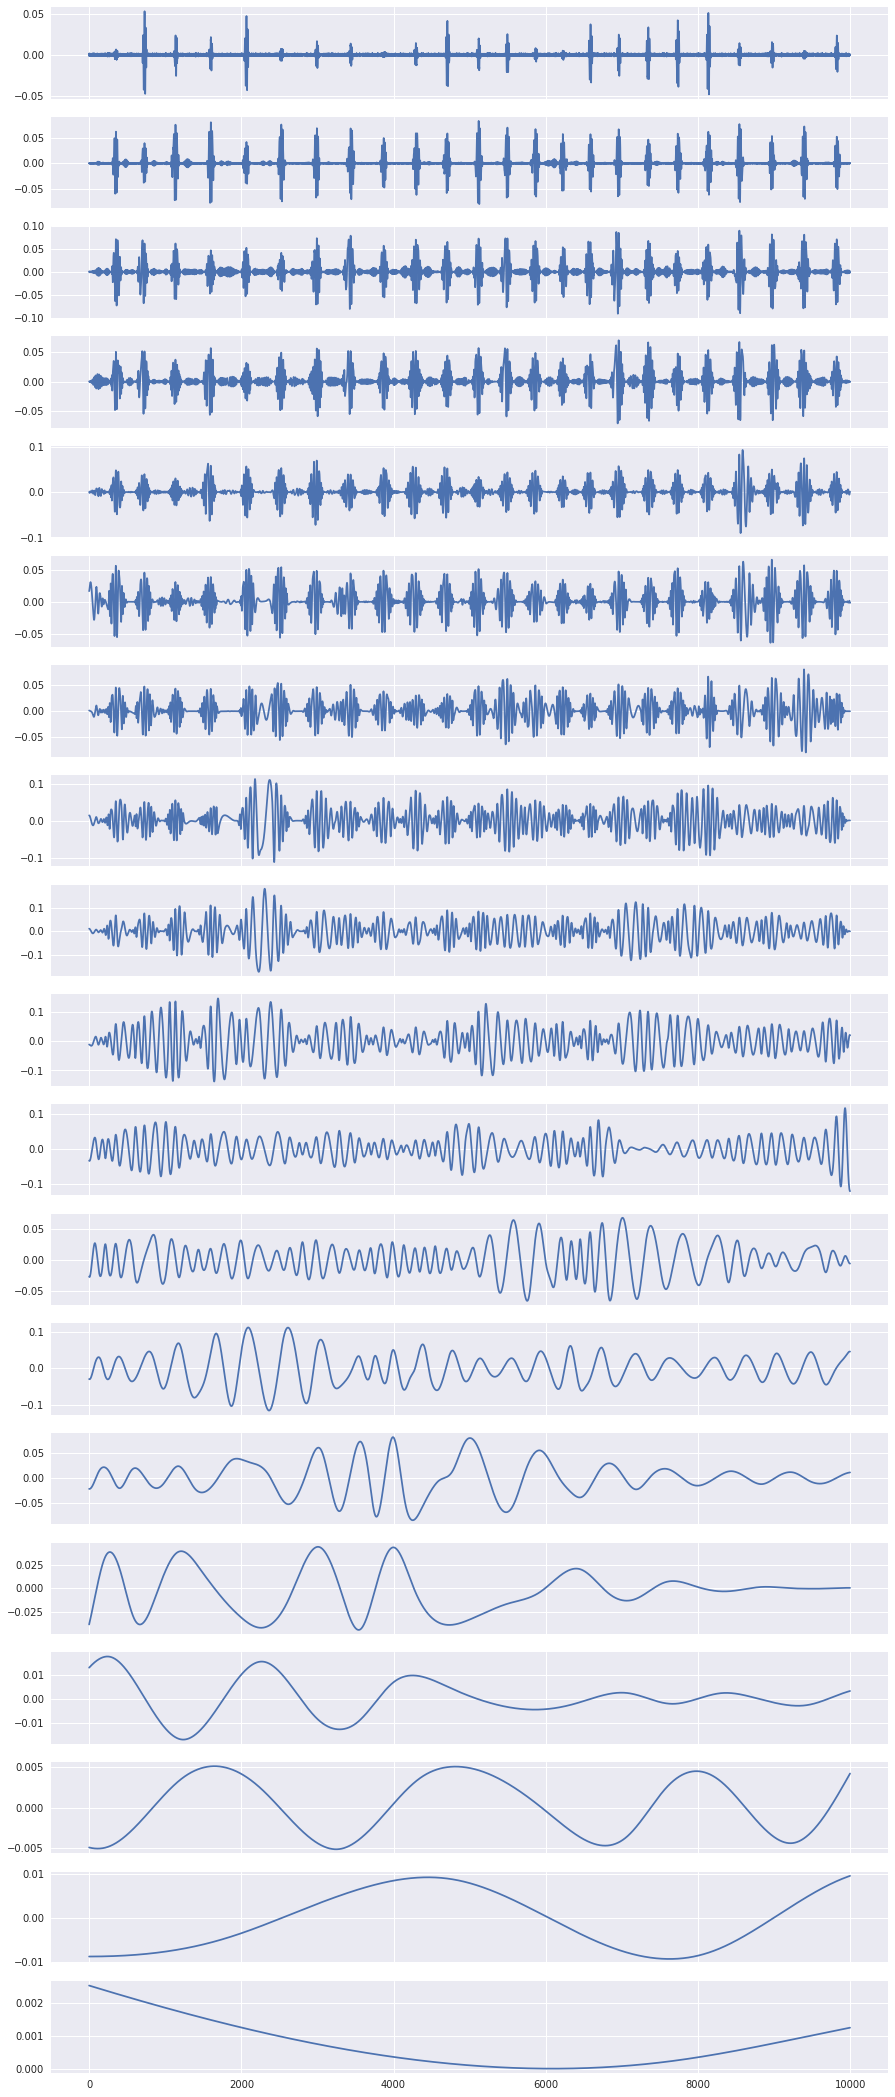

In [27]:
plots(ceIMFs)

## Instantaneous frequency

Following Han and van der Baan (2013), GEOPHYSICS 78 (2). https://doi.org/10.1190/GEO2012-0199.1

In [651]:
def inst_freq(x, dt):

    H = scipy.signal.hilbert(x)
    y = np.imag(H)
    
    dx = scipy.signal.savgol_filter(x, delta=dt, window_length=3, polyorder=2, deriv=1)
    dy = scipy.signal.savgol_filter(y, delta=dt, window_length=3, polyorder=2, deriv=1)
    
    f = (x*dy - dx*y) / (x**2 + y**2)
    
    return f / (2 * np.pi)

In [652]:
def inst_amp(x):

    H = scipy.signal.hilbert(x)
    y = np.imag(H)
    
    R = np.sqrt(x**2 + y**2)

    return R

In [686]:
f = inst_freq(ceIMFs, dt=dt)
R = inst_amp(ceIMFs)

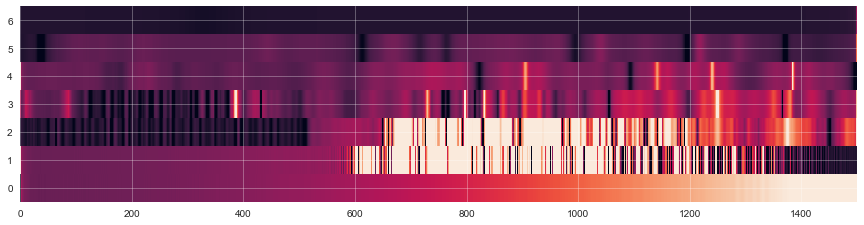

In [691]:
plt.figure(figsize=(15, 5))
plt.imshow(f, aspect=50, vmin=-2, vmax=20, origin='lower')
plt.grid(alpha=0.3)

In [701]:
f[f<1] = 0

In [702]:
from scipy.interpolate import Rbf

freq_new = np.arange(50)

spectrum = []
for f_, R_ in zip(f.T, R.T):
    func = Rbf(f_, R_, function='gaussian', epsilon=2, smooth=1e-3)
    spectrum.append(func(freq_new))
spectrum = np.array(spectrum)

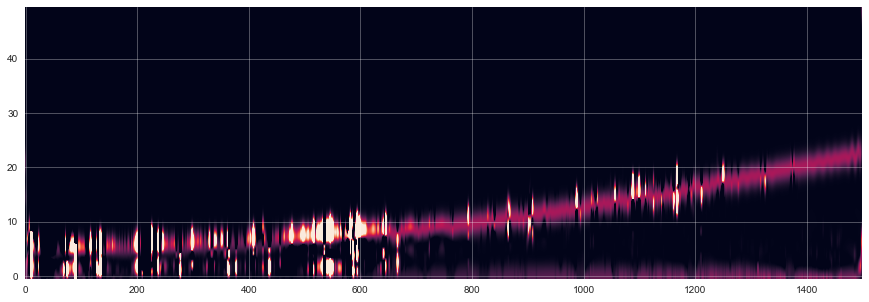

In [703]:
plt.figure(figsize=(15, 5))
plt.imshow(spectrum.T, aspect='auto', origin='lower', vmin=0, vmax=2, interpolation='bicubic')
plt.grid(alpha=0.3)

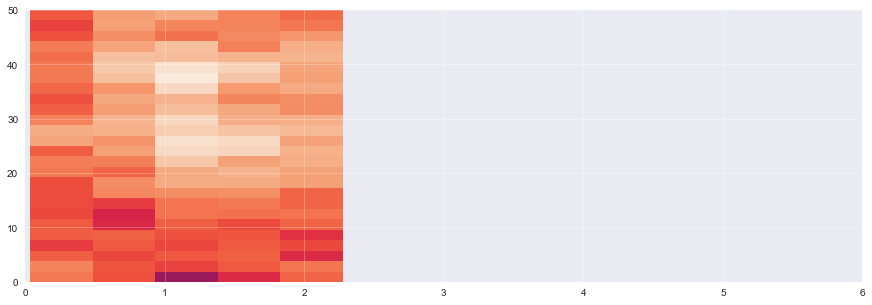

In [707]:
plt.figure(figsize=(15, 5))
plt.specgram(signal, NFFT=128, Fs=1/dt, noverlap=16)
plt.ylim((0, 50))
plt.xlim((0, 6))
plt.grid(alpha=0.25)
plt.show()